In [2]:
%pylab inline
figsize(8, 6)

Populating the interactive namespace from numpy and matplotlib


## Import

In [3]:
import pandas
import numpy
from folding_group import FoldingGroupClassifier
from rep.data import LabeledDataStorage
from rep.report import ClassificationReport
from rep.report.metrics import RocAuc
from pprint import pprint

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score

In [4]:
from utils import get_N_B_events, get_events_number, get_events_statistics

## Reading initial data

In [5]:
import root_numpy
data_nan = pandas.DataFrame(root_numpy.root2array('datasets/tracks.root', 'tracks'))

In [6]:
data_nan['etaB'] = data_nan.diff_eta + data_nan.eta

In [7]:
data_nan.head()

,index,run,event,Bmass,i,mult,partP,partPt,ptB,IPs,...,ID,veloch,signB,signTrack,Dist_phi,N_sig_sw,mu_cut,e_cut,K_cut,etaB
0,0,115839,204997902,5.309576,0,13,3.67156,0.300418,4.004197,0.816143,...,-211,0.911645,1,-1,0.114615,0.59521,0,0,0,3.395779
1,1,115839,204997902,5.309576,1,13,8.33952,1.103876,4.004197,1.375382,...,-211,0.796731,1,-1,0.051334,0.59521,0,0,0,3.395779
2,2,115839,204997902,5.309576,2,13,8.37654,1.182519,4.004197,4.338812,...,-211,0.946629,1,-1,1.856516,0.59521,0,0,0,3.395779
3,3,115839,204997902,5.309576,3,13,25.72961,0.905010,4.004197,2.287509,...,211,1.058989,1,1,0.577419,0.59521,0,0,0,3.395779
4,4,115839,204997902,5.309576,4,13,3.70597,0.516123,4.004197,0.562424,...,211,1.042135,1,1,1.314513,0.59521,0,0,0,3.395779


In [8]:
event_id_column = 'event_id'
event_id = data_nan.run.apply(str) + '_' + data_nan.event.apply(str)
data_nan['group_column'] = numpy.unique(event_id, return_inverse=True)[1]
data_nan[event_id_column] = event_id

In [9]:
get_events_statistics(data_nan)

{'Events': 1005757, 'tracks': 27156193}

In [10]:
get_N_B_events()

742867.7142562866

## Remove rows with NAN from data

In [11]:
data = data_nan.dropna()
len(data_nan), len(data), get_events_statistics(data)

(27156193, 27156190, {'Events': 1005757, 'tracks': 27156190})

In [12]:
del data_nan

In [13]:
for column in data.columns:
    if (data[column].dtype == 'int64') and (data[column].max() < 2 ** 30):
        data[column] = data[column].astype('int32')
    if data[column].dtype == 'float64':
        data[column] = data[column].astype('float32')

## Add diff_pt and cos(diff_phi)

In [14]:
# add different between max pt in event and pt for each track
def add_diff_pt(data):
    max_pt = group_max(data[event_id_column].values.astype(str), data.partPt.values)
    data.loc[:, 'diff_pt'] = max_pt - data['partPt'].values

# max is computing max over tracks in the same event for some data (column)
def group_max(groups, data):
    # computing unique integer id for each group
    assert len(groups) == len(data)
    _, event_id = numpy.unique(groups, return_inverse=True)
    max_over_event = numpy.zeros(max(event_id) + 1) - numpy.inf
    numpy.maximum.at(max_over_event, event_id, data)
    return max_over_event[event_id]

In [15]:
# add diff pt
add_diff_pt(data)
# add cos(diff_phi)
data.loc[:, 'cos_diff_phi'] = numpy.cos(data.diff_phi.values)

## Add max, sum among PIDs

In [16]:
from itertools import combinations
PIDs = {'k': data.PIDNNk.values,
        'e': data.PIDNNe.values,
        'mu': data.PIDNNm.values,
       }
for (pid_name1, pid_values1), (pid_name2, pid_values2) in combinations(PIDs.items(), 2):
    data.loc[:, 'max_PID_{}_{}'.format(pid_name1, pid_name2)] = numpy.maximum(pid_values1, pid_values2)
    data.loc[:, 'sum_PID_{}_{}'.format(pid_name1, pid_name2)] = pid_values1 + pid_values2

## define `label` = `signB` * `signTrack`

* if > 0 (same sign) - label **1**
* if < 0 (different sign) - label **0**

In [17]:
data.loc[:, 'label'] = (data.signB.values * data.signTrack.values > 0) * 1

In [18]:
', '.join(data.columns)

'index, run, event, Bmass, i, mult, partP, partPt, ptB, IPs, IP, IPerr, partlcs, EOverP, ghostProb, IPPU, nnkrec, PIDNNk, PIDNNpi, PIDNNp, PIDNNm, PIDNNe, diff_eta, diff_phi, phi, eta, proj, ID, veloch, signB, signTrack, Dist_phi, N_sig_sw, mu_cut, e_cut, K_cut, etaB, group_column, event_id, diff_pt, cos_diff_phi, max_PID_mu_k, sum_PID_mu_k, max_PID_mu_e, sum_PID_mu_e, max_PID_k_e, sum_PID_k_e, label'

## Apply ghost prob cut

In [19]:
initial_cut = '(ghostProb < 0.4)'
data = data.query(initial_cut)

In [20]:
get_events_statistics(data)

{'Events': 1005751, 'tracks': 25567912}

## Leave not muons, kaons, electrons, protons, pions

In [21]:
threshold_kaon = 0.
threshold_muon = 0.
threshold_electron = 0.
threshold_pion = 0.
threshold_proton = 0.
cut_pid = " ( (PIDNNk > {trk}) | (PIDNNm > {trm}) | (PIDNNe > {tre}) | (PIDNNpi > {trpi}) | (PIDNNp > {trp})) "
cut_pid = cut_pid.format(trk=threshold_kaon, trm=threshold_muon, tre=threshold_electron, trpi=threshold_pion, 
                         trp=threshold_proton)
    
data = data.query(cut_pid)

In [22]:
get_events_statistics(data)

{'Events': 1005751, 'tracks': 25531030}

# Alex experiments

## Renaming

In [23]:
names_mapping = {
    'Bmass'    : 'sig_mass',
    'EOverP'   : 'part_e_over_p',
    'IP'       : 'part_ip',
    'IPPU'     : 'part_ippu',
    'IPerr'    : 'part_ip_err',
    'IPs'      : 'part_ip_significance',
    'PIDNNe'   : 'part_pid_e',
    'PIDNNk'   : 'part_pid_k',
    'PIDNNm'   : 'part_pid_m',
    'PIDNNp'   : 'part_pid_p',
    'PIDNNpi'  : 'part_pid_pi',
    'diff_eta' : 'both_diff_eta',
    'diff_phi' : 'both_diff_phi',
    'eta'      : 'part_eta',
    'ghostProb': 'part_pid_ghost',
    'nnkrec'   : 'n_reconstructed_vertices',
    'partP'    : 'part_p',
    'partPt'   : 'part_pt',
    'partlcs'  : 'part_lcs',
    'proj'     : 'both_proj',
    'ptB'      : 'sig_pt',
    'signB'    : 'sig_sign',
    'etaB'     : 'sig_eta',
    'signTrack': 'part_sign',
    'veloch'   : 'part_veloch',
}

In [24]:
# _, delegates = numpy.unique(data[event_id_column], return_index=True)
# columns_old = [old_name for old_name, new_name in names_mapping.items() if 'sig_' in new_name]
# columns_new = [new_name for old_name, new_name in names_mapping.items() if 'sig_' in new_name]

In [25]:
# short_data = data[columns_old].iloc[delegates, :]
# short_data = short_data.rename(columns=names_mapping)

# short_data.head()

In [26]:
# from decisiontrain import DecisionTrainClassifier
# clf = FoldingGroupClassifier(DecisionTrainClassifier(n_estimators=1000, depth=4), n_folds=2)
# clf.fit(short_data[['sig_pt', 'sig_eta', 'sig_mass']], (short_data['sig_sign'] + 1) // 2)

In [27]:
# report = clf.test_on(short_data[['sig_pt', 'sig_eta', 'sig_mass']], (short_data['sig_sign'] + 1) // 2)

In [28]:
# report.learning_curve(RocAuc(), steps=1)

## Simplified training

In [29]:
old_features = list(names_mapping.keys()) + ['label', 'group_column', 'N_sig_sw', 'event_id']
data_trimmed = data[data.N_sig_sw > 1.][old_features].rename(columns=names_mapping)

## Adding features

In [30]:
data_trimmed['both_cos_diff_phi'] = numpy.cos(data_trimmed.both_diff_phi)

In [31]:
def theta_from_eta(eta):
    return 2 * numpy.arctan(numpy.exp(-eta))

data_trimmed['sig_theta'] = theta_from_eta(data_trimmed['sig_eta'])
data_trimmed['part_theta'] = theta_from_eta(data_trimmed['part_eta'])
data_trimmed['both_diff_theta'] = numpy.cos(data_trimmed['sig_theta'] - data_trimmed['part_theta'])
# from http://math.stackexchange.com/questions/231221/great-arc-distance-between-two-points-on-a-unit-sphere
data_trimmed['both_cos_between'] = numpy.cos(data_trimmed['sig_theta']) * numpy.cos(data_trimmed['part_theta']) \
    + numpy.sin(data_trimmed['sig_theta']) * numpy.sin(data_trimmed['part_theta']) * data_trimmed['both_cos_diff_phi']

In [32]:
## немного иначе
part_pz = data_trimmed['part_pt'] * numpy.sinh(data_trimmed['part_eta'])
sig_pz = data_trimmed['sig_pt'] * numpy.sinh(data_trimmed['sig_eta'])

In [33]:
# data_trimmed.both_cos_diff_phi

In [34]:
prod = part_pz * sig_pz + data_trimmed['part_pt'] * data_trimmed['sig_pt'] * data_trimmed['both_cos_diff_phi']

In [35]:
data_trimmed['both_pproj_to_B'] = prod / (data_trimmed['sig_pt'] * numpy.cosh(data_trimmed['sig_eta']))
data_trimmed['both_pt_wrt_B'] = data_trimmed['part_p'] * numpy.sqrt(1 - data_trimmed.both_cos_between ** 2)

proj2 = prod / (data_trimmed['part_pt'] * numpy.cosh(data_trimmed['part_eta']))

In [36]:
## pT with respect to projection

In [37]:
train_features = [name for name in data_trimmed.columns if ('part_' in name) or ('both_' in name)]

In [38]:
train_features = list(set(train_features) - {'part_sign', 'part_theta', 'part_sign', 'both_diff_phi'})

In [39]:
sorted(train_features)

['both_cos_between',
 'both_cos_diff_phi',
 'both_diff_eta',
 'both_diff_theta',
 'both_pproj_to_B',
 'both_proj',
 'both_pt_wrt_B',
 'part_e_over_p',
 'part_eta',
 'part_ip',
 'part_ip_err',
 'part_ip_significance',
 'part_ippu',
 'part_lcs',
 'part_p',
 'part_pid_e',
 'part_pid_ghost',
 'part_pid_k',
 'part_pid_m',
 'part_pid_p',
 'part_pid_pi',
 'part_pt',
 'part_veloch']

In [40]:
%%time
from decisiontrain import DecisionTrainClassifier
clf = FoldingGroupClassifier(DecisionTrainClassifier(n_estimators=2000, n_threads=14), n_folds=2, 
                             train_features=train_features,
                             group_feature='group_column', )
clf.fit(data_trimmed, data_trimmed['label'])

CPU times: user 45min 18s, sys: 4min 16s, total: 49min 35s
Wall time: 10min 6s


In [41]:
sorted(zip(clf.estimators[0].feature_importances_, train_features))

[(0.017500000000000002, 'both_pproj_to_B'),
 (0.02, 'part_p'),
 (0.022499999999999999, 'both_diff_theta'),
 (0.024, 'part_e_over_p'),
 (0.028500000000000001, 'part_eta'),
 (0.029999999999999999, 'both_pt_wrt_B'),
 (0.030499999999999999, 'part_veloch'),
 (0.031, 'part_lcs'),
 (0.0315, 'both_diff_eta'),
 (0.035000000000000003, 'both_cos_between'),
 (0.036499999999999998, 'part_pid_pi'),
 (0.0395, 'part_pid_ghost'),
 (0.041000000000000002, 'part_ip_err'),
 (0.041000000000000002, 'part_ippu'),
 (0.045499999999999999, 'both_cos_diff_phi'),
 (0.045999999999999999, 'part_pid_m'),
 (0.048000000000000001, 'part_pid_e'),
 (0.057000000000000002, 'part_ip_significance'),
 (0.057000000000000002, 'part_pid_p'),
 (0.070999999999999994, 'part_ip'),
 (0.073499999999999996, 'part_pid_k'),
 (0.081500000000000003, 'both_proj'),
 (0.091999999999999998, 'part_pt')]

In [42]:
sorted(zip(clf.estimators[0].feature_importances_, train_features))

[(0.017500000000000002, 'both_pproj_to_B'),
 (0.02, 'part_p'),
 (0.022499999999999999, 'both_diff_theta'),
 (0.024, 'part_e_over_p'),
 (0.028500000000000001, 'part_eta'),
 (0.029999999999999999, 'both_pt_wrt_B'),
 (0.030499999999999999, 'part_veloch'),
 (0.031, 'part_lcs'),
 (0.0315, 'both_diff_eta'),
 (0.035000000000000003, 'both_cos_between'),
 (0.036499999999999998, 'part_pid_pi'),
 (0.0395, 'part_pid_ghost'),
 (0.041000000000000002, 'part_ip_err'),
 (0.041000000000000002, 'part_ippu'),
 (0.045499999999999999, 'both_cos_diff_phi'),
 (0.045999999999999999, 'part_pid_m'),
 (0.048000000000000001, 'part_pid_e'),
 (0.057000000000000002, 'part_ip_significance'),
 (0.057000000000000002, 'part_pid_p'),
 (0.070999999999999994, 'part_ip'),
 (0.073499999999999996, 'part_pid_k'),
 (0.081500000000000003, 'both_proj'),
 (0.091999999999999998, 'part_pt')]

In [43]:
report = clf.test_on(data_trimmed, data_trimmed['label'])

KFold prediction using folds column


KFold prediction using folds column


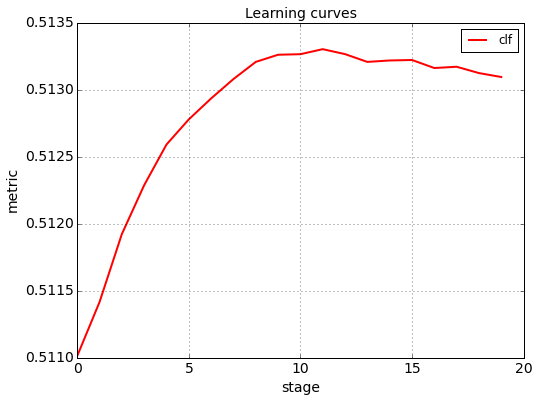

In [44]:
report.learning_curve(RocAuc(), steps=1)


## Распределение тегирующих треков

In [46]:
from scipy.special import logit
track_predictions = logit(clf.predict_proba(data_trimmed)[:, 1])

KFold prediction using folds column


In [47]:
from utils import group_max
max_pred = group_max(data_trimmed.group_column, track_predictions)
min_pred = -group_max(data_trimmed.group_column, -track_predictions)

In [48]:
roc_auc_score(data_trimmed.sig_sign, track_predictions)

0.50024584497191193

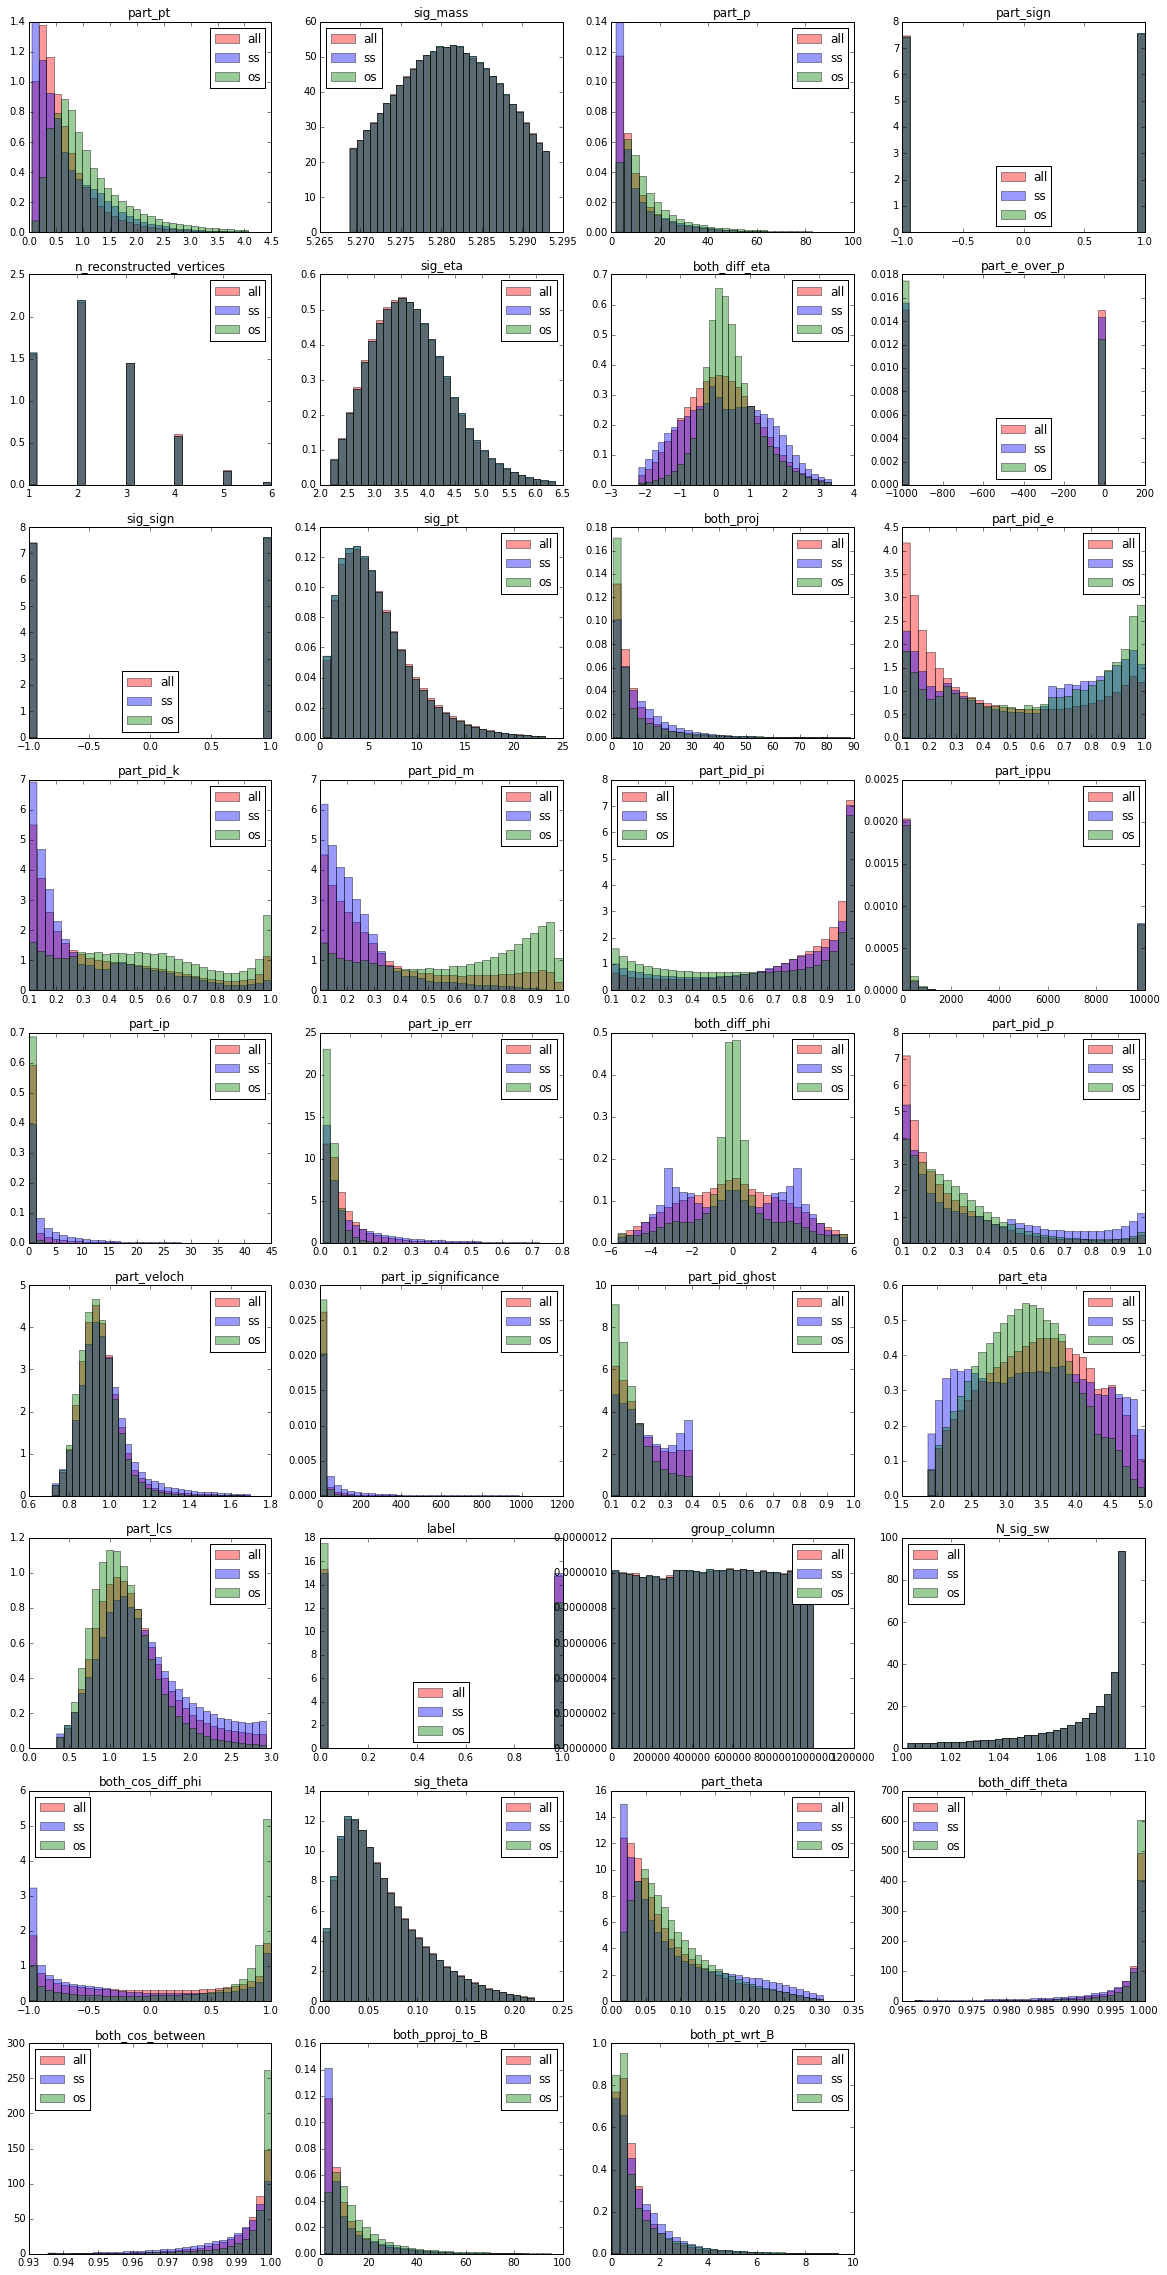

In [49]:
plt.figure(figsize=[20, 40])
plotted_columns = data_trimmed.columns
plotted_columns = plotted_columns[data_trimmed.dtypes != 'O']


for i, column in enumerate(plotted_columns, 1):
    plt.subplot(9, 4, i)
    plot_margins = numpy.percentile(data_trimmed[column].values, [0.5, 99.5])
    plot_config = dict(alpha=0.4, bins=30, normed=True, range=plot_margins)
    if 'pid' in column:
        plot_config['range'] = (0.1, 1)
    plt.hist(data_trimmed[column].values, label='all', **plot_config)
    plt.hist(data_trimmed[column].values[max_pred == track_predictions], label='ss', **plot_config)
    plt.hist(data_trimmed[column].values[min_pred == track_predictions], label='os', **plot_config)
    plt.title(column)
    plt.legend(loc='best')


### Объединяем на коленке

In [51]:
from sklearn.linear_model import LogisticRegression

In [ ]:
# track_predictions.min(), track_predictions.max()

In [52]:
calibrator = FoldingGroupClassifier(LogisticRegression(), n_folds=2, 
                                    train_features=['p'],
                                    group_feature='group_column', )

X_ = pandas.DataFrame(dict(p=track_predictions, group_column=data_trimmed.group_column))

In [53]:
calibrator.fit(X_, data_trimmed.label)

calibrated_predictions = logit(calibrator.predict_proba(X_)[:, 1])

KFold prediction using folds column


In [54]:
_, group_indices = numpy.unique(data_trimmed.group_column, return_inverse=True)

In [55]:
# event_predictions = numpy.bincount(group_indices, weights=data_trimmed['part_sign'].values * calibrated_predictions)
event_predictions = numpy.bincount(group_indices, weights=data_trimmed['part_sign'].values * track_predictions)

event_predictions /= numpy.sqrt(numpy.bincount(group_indices) + 1)

sig_sign = numpy.bincount(group_indices, weights=data_trimmed['sig_sign'].values) / numpy.bincount(group_indices)


# event_predictions = numpy.bincount(group_indices, weights=data_trimmed['part_sign'] * track_predictions) 


In [56]:
print roc_auc_score(sig_sign, event_predictions, sample_weight=data['N_sig_sw'])
print roc_auc_score(data_trimmed.label, track_predictions)
print roc_auc_score(data_trimmed.label, calibrated_predictions)

0.640769302845
0.513096629759
0.513094138395


In [57]:
data_trimmed.label.values[:20], (data_trimmed.sig_sign * data_trimmed.part_sign).values[:20]

(array([0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0]),
 array([-1.,  1.,  1.,  1., -1., -1.,  1.,  1.,  1., -1., -1.,  1., -1.,
        -1.,  1.,  1.,  1.,  1., -1., -1.], dtype=float32))

In [58]:
def test_quality_on_subset_of_features(train_features):
    clf = FoldingGroupClassifier(DecisionTrainClassifier(n_estimators=3000, n_threads=14, learning_rate=0.03), n_folds=2, 
                                 train_features=train_features,
                                 group_feature='group_column', )
    %time clf.fit(data_trimmed, data_trimmed['label'])
    pprint(sorted(zip(clf.estimators[0].feature_importances_, train_features)))
    report = clf.test_on(data_trimmed, data_trimmed['label'])
    report.learning_curve(RocAuc(), steps=2).plot()
    track_predictions = logit(clf.predict_proba(data_trimmed)[:, 1])
    event_predictions = numpy.bincount(group_indices, weights=data_trimmed['part_sign'].values * track_predictions)
    event_predictions /= numpy.sqrt(numpy.bincount(group_indices) + 1)
    sig_sign = numpy.bincount(group_indices, weights=data_trimmed['sig_sign'].values) / numpy.bincount(group_indices)
    print roc_auc_score(sig_sign, event_predictions, sample_weight=data['N_sig_sw'])
    print roc_auc_score(data_trimmed.label, track_predictions)
    return clf

CPU times: user 1h 4min 13s, sys: 7min 1s, total: 1h 11min 15s
Wall time: 11min 23s
[(0.017000000000000001, 'both_pproj_to_B'),
 (0.021000000000000001, 'both_diff_theta'),
 (0.021333333333333333, 'part_p'),
 (0.021999999999999999, 'part_eta'),
 (0.026333333333333334, 'part_e_over_p'),
 (0.027, 'both_pt_wrt_B'),
 (0.030333333333333334, 'part_lcs'),
 (0.032666666666666663, 'both_cos_between'),
 (0.033333333333333333, 'both_diff_eta'),
 (0.035333333333333335, 'part_ippu'),
 (0.036666666666666667, 'part_ip_err'),
 (0.036999999999999998, 'part_pid_pi'),
 (0.040666666666666663, 'part_pid_ghost'),
 (0.041000000000000002, 'part_veloch'),
 (0.048333333333333332, 'part_pid_m'),
 (0.048666666666666664, 'both_cos_diff_phi'),
 (0.051999999999999998, 'part_pid_e'),
 (0.057000000000000002, 'part_pid_p'),
 (0.058000000000000003, 'part_ip_significance'),
 (0.066666666666666666, 'part_ip'),
 (0.069666666666666668, 'part_pid_k'),
 (0.081333333333333327, 'both_proj'),
 (0.096666666666666665, 'part_pt')]
K

FoldingGroupClassifier(base_estimator=DecisionTrainClassifier(bootstrap=True, depth=6, l2_regularization=100.0,
            learning_rate=0.03, loss=None, max_features=0.8,
            n_estimators=3000, n_threads=14, train_features=None,
            update_step=4, use_friedman_mse=True),
            group_feature='group_column', n_folds=2, parallel_profile=None,
            random_state=None,
            train_features=['part_e_over_p', 'part_ip_err', 'both_cos_diff_phi', 'both_pproj_to_B', 'part_pid_ghost', 'part_lcs', 'part_eta', 'part_p', 'both_diff_theta', 'both_pt_wrt_B', 'part_ippu', 'part_ip', 'both_cos_between', 'part_pt', 'part_veloch', 'both_diff_eta', 'part_pid_pi', 'part_pid_p', 'both_proj', 'part_pid_e', 'part_pid_k', 'part_ip_significance', 'part_pid_m'])

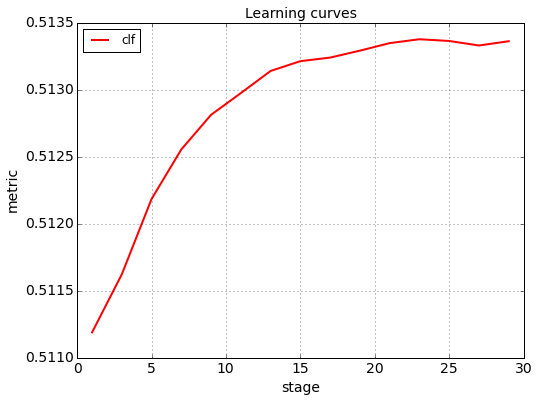

In [59]:
test_quality_on_subset_of_features(train_features=train_features)

CPU times: user 34min 7s, sys: 7min 1s, total: 41min 9s
Wall time: 8min 53s
[(0.11799999999999999, 'sig_sign'),
 (0.16166666666666665, 'both_pproj_to_B'),
 (0.17433333333333334, 'part_p'),
 (0.26733333333333331, 'both_cos_between'),
 (0.27866666666666667, 'both_diff_eta')]
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
0.592471063137
0.508632266511


FoldingGroupClassifier(base_estimator=DecisionTrainClassifier(bootstrap=True, depth=6, l2_regularization=100.0,
            learning_rate=0.03, loss=None, max_features=0.8,
            n_estimators=3000, n_threads=14, train_features=None,
            update_step=4, use_friedman_mse=True),
            group_feature='group_column', n_folds=2, parallel_profile=None,
            random_state=None,
            train_features=['sig_sign', 'part_p', 'both_diff_eta', 'both_cos_between', 'both_pproj_to_B'])

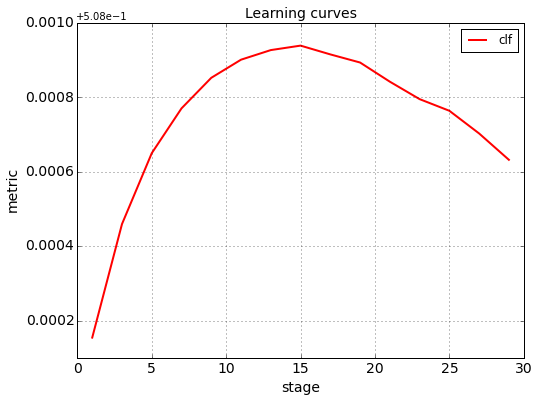

In [60]:
momentum_features = ['sig_sign', 'part_p', 'both_diff_eta', 'both_cos_between', 'both_pproj_to_B']
test_quality_on_subset_of_features(train_features=momentum_features)

CPU times: user 43min 33s, sys: 7min 2s, total: 50min 35s
Wall time: 9min 34s
[(0.060333333333333336, 'sig_sign'),
 (0.064666666666666664, 'part_p'),
 (0.066000000000000003, 'both_pproj_to_B'),
 (0.09633333333333334, 'sig_eta'),
 (0.128, 'both_cos_between'),
 (0.13200000000000001, 'both_diff_eta'),
 (0.14499999999999999, 'both_cos_diff_phi'),
 (0.14899999999999999, 'sig_pt'),
 (0.15866666666666668, 'part_pt')]
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
0.608644843102
0.510370412255


FoldingGroupClassifier(base_estimator=DecisionTrainClassifier(bootstrap=True, depth=6, l2_regularization=100.0,
            learning_rate=0.03, loss=None, max_features=0.8,
            n_estimators=3000, n_threads=14, train_features=None,
            update_step=4, use_friedman_mse=True),
            group_feature='group_column', n_folds=2, parallel_profile=None,
            random_state=None,
            train_features=['sig_sign', 'part_p', 'part_pt', 'both_cos_diff_phi', 'sig_pt', 'sig_eta', 'both_diff_eta', 'both_cos_between', 'both_pproj_to_B'])

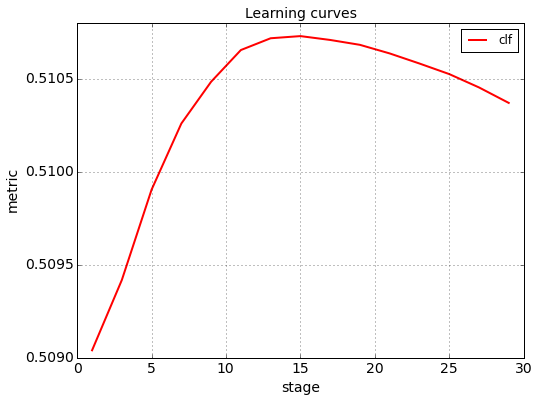

In [61]:
momentum_features = ['sig_sign', 'part_p', 'part_pt', 'both_cos_diff_phi', 'sig_pt', 'sig_eta',
                     'both_diff_eta', 'both_cos_between', 'both_pproj_to_B']
test_quality_on_subset_of_features(train_features=momentum_features)

CPU times: user 27min 41s, sys: 7min 6s, total: 34min 48s
Wall time: 8min 3s
[(1.0, 'part_pt')]
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
0.583450853825
0.505421770684


FoldingGroupClassifier(base_estimator=DecisionTrainClassifier(bootstrap=True, depth=6, l2_regularization=100.0,
            learning_rate=0.03, loss=None, max_features=0.8,
            n_estimators=3000, n_threads=14, train_features=None,
            update_step=4, use_friedman_mse=True),
            group_feature='group_column', n_folds=2, parallel_profile=None,
            random_state=None, train_features=['part_pt'])

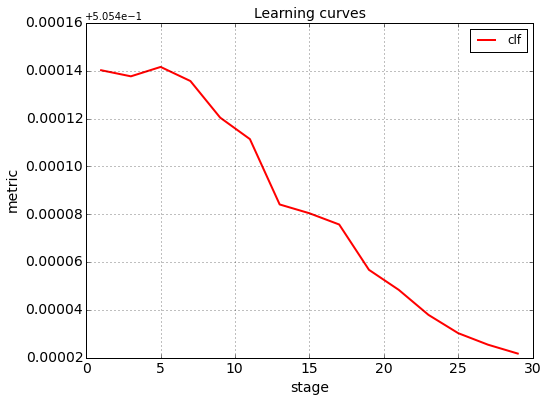

In [62]:
momentum_features = ['part_pt']
test_quality_on_subset_of_features(train_features=momentum_features)

In [63]:
train_features2 = list(train_features(train_features) - {'both_proj'} )
len(train_features), len(train_features2)
test_quality_on_subset_of_features(train_features=train_features2)

TypeError: 'list' object is not callable

In [ ]:
# from utils import prepare_B_data_for_given_part
# Bdata_prepared = prepare_B_data_for_given_part(clf, [data_trimmed], logistic=True, sign_part_column='part_sign')

## Комбинируем при помощи машинного обучения

In [ ]:
from rep.metaml import FoldingClassifier

In [ ]:
ml_combining = {}

event_predictions = numpy.bincount(group_indices, weights=data_trimmed['part_sign'].values * track_predictions)
event_predictions /= numpy.sqrt(numpy.bincount(group_indices) + 1)

ml_combining['pred_sum'] = numpy.bincount(group_indices, weights=data_trimmed['part_sign'].values * track_predictions)
serious_pred = numpy.where(abs(track_predictions) < 0.05, 0, track_predictions)
ml_combining['pred_serious_sum'] = numpy.bincount(group_indices, weights=data_trimmed['part_sign'].values * serious_pred)

serious_pred = numpy.where(abs(track_predictions) < 0.08, 0, track_predictions)
ml_combining['pred_serious_sum2'] = numpy.bincount(group_indices, weights=data_trimmed['part_sign'].values * serious_pred)


ml_combining['n_tracks'] = numpy.bincount(group_indices)
ml_combining['pred_mean'] = ml_combining['pred_sum'] / ml_combining['n_tracks']
ml_combining['pred_sqrt'] = ml_combining['pred_sum'] / numpy.sqrt(ml_combining['n_tracks'] + 1)

ml_combining['sign_sum'] = numpy.bincount(group_indices, weights=data_trimmed['part_sign'].values)
ml_combining['sign_mean'] = ml_combining['sign_sum'] / ml_combining['n_tracks']
ml_combining['sig_pt'] = numpy.bincount(group_indices, weights=data_trimmed['sig_pt']) / ml_combining['n_tracks'] 
ml_combining['sig_eta'] = numpy.bincount(group_indices, weights=data_trimmed['sig_eta']) / ml_combining['n_tracks']
ml_combining['nnkrec'] = numpy.bincount(group_indices, weights=data_trimmed['n_reconstructed_vertices']) / ml_combining['n_tracks']


X_ = pandas.DataFrame(ml_combining)


sig_sign = numpy.bincount(group_indices, weights=data_trimmed['sig_sign'].values) / numpy.bincount(group_indices)


combine_clf = FoldingClassifier(DecisionTrainClassifier(n_estimators=3000, n_threads=14, learning_rate=0.03), n_folds=2)
%time combine_clf.fit(X_, (sig_sign + 1) // 2)

In [ ]:
sorted(zip(combine_clf.estimators[0].feature_importances_, X_.columns))

In [ ]:
combine_clf.test_on(X_, (sig_sign + 1) // 2).learning_curve(RocAuc(), steps=1)

In [ ]:
print roc_auc_score(sig_sign, event_predictions)

# Комбинируем умно

## Combining formula 

$$ 
p_r / (1 - p_r) = \prod_i (p_i / (1 - p_i))^{sign track}
$$

$$
lpr = logit(p_r) \qquad lp_i = logit(p_i)
$$

$$
p_r / (1 - p_r) = e^{lpr}
$$
$$
p_i / (1 - p_i) = e^{lpi}
$$
$$
e^{lpr} = \prod_i e^{lpi * sign track}
$$

$$
lpr = \sum_i lpi * sign track
$$

## Calculating tagging efficiency ($\epsilon_{tag}$)

$$N (\text{passed selection}) = \sum_{\text{passed selection}} sw_i$$

$$N (\text{all events}) = \sum_{\text{all events}} sw_i,$$

where $sw_i$ - sPLot weight (sWeight for signal)

$$\epsilon_{tag} = \frac{N (\text{passed selection})} {N (\text{all events})}$$

$$\Delta\epsilon_{tag} = \frac{\sqrt{N (\text{passed selection})}} {N (\text{all events})}$$

In [19]:
N_B_passed = float(get_events_number(data))
tagging_efficiency = N_B_passed / get_N_B_events()
tagging_efficiency_delta = sqrt(N_B_passed) / get_N_B_events()
tagging_efficiency, tagging_efficiency_delta

(0.9998594749632361, 0.0011601489232199002)

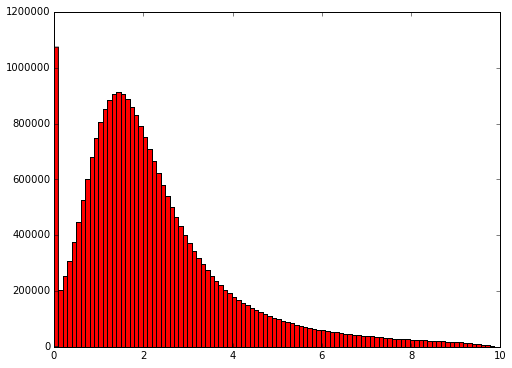

In [20]:
hist(data.diff_pt.values, bins=100)
pass

## Choose most probable B-events

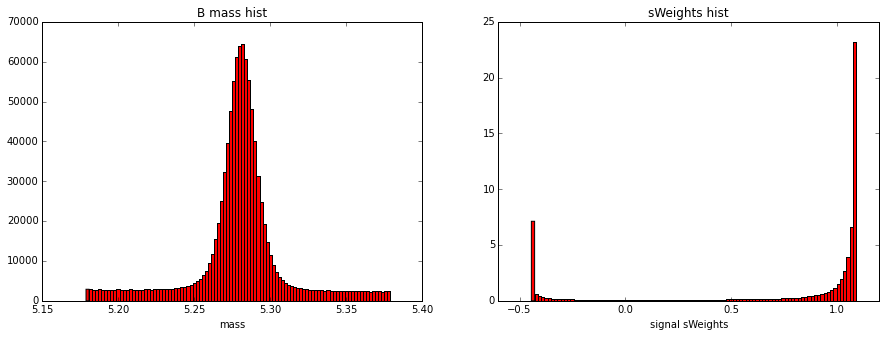

In [21]:
_, take_indices = numpy.unique(data[event_id_column], return_index=True)

figure(figsize=[15, 5])

subplot(1, 2, 1)
hist(data.Bmass.values[take_indices], bins=100)
title('B mass hist')
xlabel('mass')

subplot(1, 2, 2)
hist(data.N_sig_sw.values[take_indices], bins=100, normed=True)
title('sWeights hist')
xlabel('signal sWeights')
plt.savefig('img/Bmass_less_PID.png' , format='png')

### Define B-like events for training 

Events with low sWeight still will be used only to test quality.

In [22]:
sweight_threshold = 1.
data_sw_passed = data[data.N_sig_sw > sweight_threshold]
data_sw_not_passed = data[data.N_sig_sw <= sweight_threshold]
get_events_statistics(data_sw_passed)

{'Events': 614418, 'tracks': 15266383}

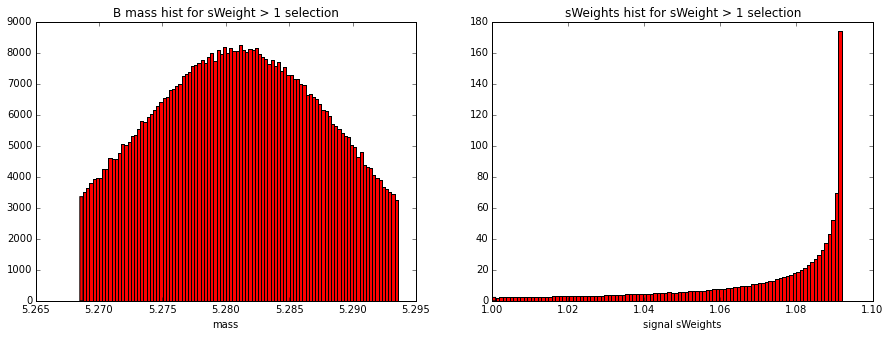

In [23]:
_, take_indices = numpy.unique(data_sw_passed[event_id_column], return_index=True)

figure(figsize=[15, 5])
subplot(1, 2, 1)
hist(data_sw_passed.Bmass.values[take_indices], bins=100)
title('B mass hist for sWeight > 1 selection')
xlabel('mass')

subplot(1, 2, 2)
hist(data_sw_passed.N_sig_sw.values[take_indices], bins=100, normed=True)
title('sWeights hist for sWeight > 1 selection')
xlabel('signal sWeights')
plt.savefig('img/Bmass_selected_less_PID.png' , format='png')

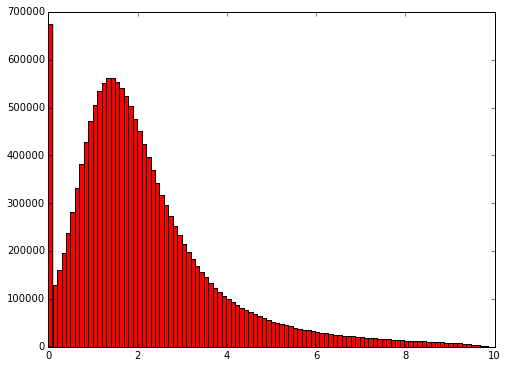

In [24]:
hist(data_sw_passed.diff_pt.values, bins=100)
pass

# Main idea: 
## find tracks, which can help reconstruct the sign of B if you know track sign.

`label` = `signB` * `signTrack`
* the highest output means that this is same sign B as track
* the lowest output means that this is opposite sign B than track

## Define features

In [25]:
features = list(set(data.columns) - {'index', 'run', 'event', 'i', 'signB', 'signTrack', 'N_sig_sw', 'Bmass', 'mult', 
                                     'PIDNNp', 'PIDNNpi', 'label', 'thetaMin', 'Dist_phi', event_id_column, 
                                     'mu_cut', 'e_cut', 'K_cut', 'ID', 'diff_phi', 'group_column'})
features

['cos_diff_phi',
 'diff_pt',
 'partPt',
 'partP',
 'nnkrec',
 'diff_eta',
 'EOverP',
 'ptB',
 'sum_PID_mu_k',
 'proj',
 'PIDNNe',
 'sum_PID_k_e',
 'PIDNNk',
 'sum_PID_mu_e',
 'PIDNNm',
 'phi',
 'IP',
 'IPerr',
 'IPs',
 'veloch',
 'max_PID_k_e',
 'ghostProb',
 'IPPU',
 'eta',
 'max_PID_mu_e',
 'max_PID_mu_k',
 'partlcs']

## PID pairs scatters

/moosefs/miniconda/envs/ipython_py2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


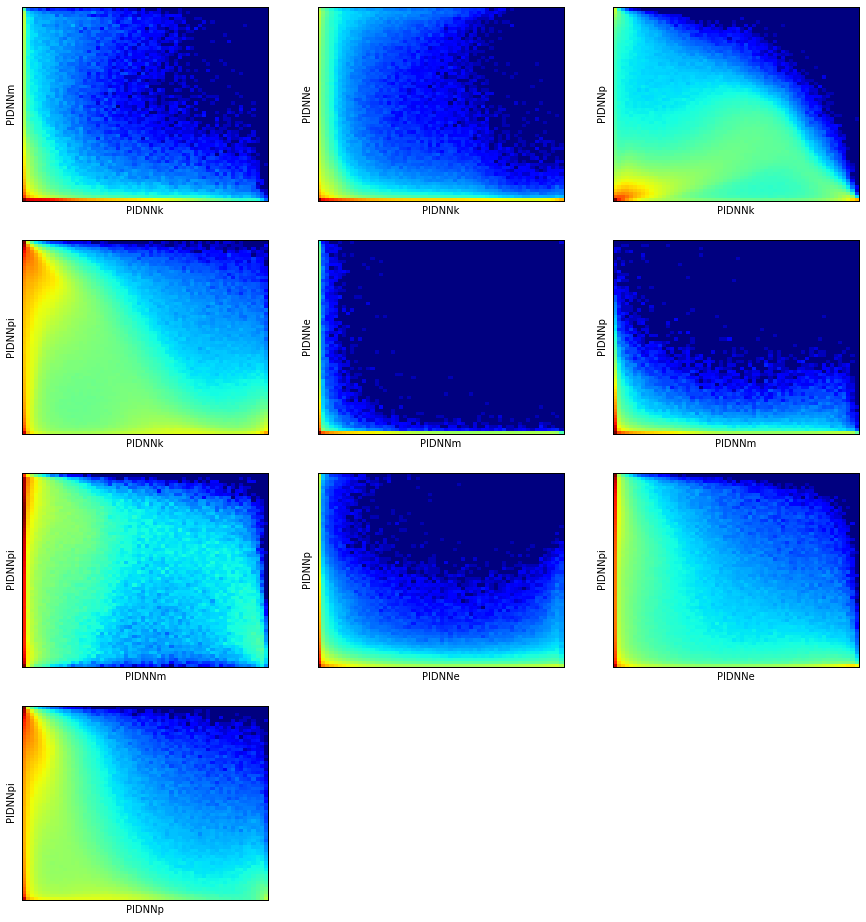

In [26]:
figure(figsize=[15, 16])
bins = 60
step = 3
for i, (feature1, feature2) in enumerate(combinations(['PIDNNk', 'PIDNNm', 'PIDNNe', 'PIDNNp', 'PIDNNpi'], 2)):
    subplot(4, 3, i + 1)
    Z, (x, y) = numpy.histogramdd(data_sw_passed[[feature1, feature2]].values, bins=bins, range=([0, 1], [0, 1]))
    pcolor(numpy.log(Z).T, vmin=0)
    xlabel(feature1)
    ylabel(feature2)
    xticks(numpy.arange(bins, step), x[::step]), yticks(numpy.arange(bins, step), y[::step])
plt.savefig('img/PID_selected_less_PID.png' , format='png')

## pt

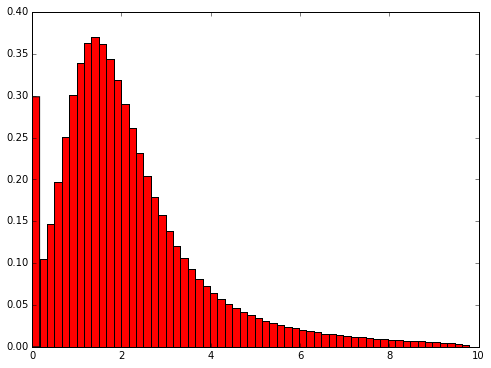

In [27]:
hist(data_sw_passed.diff_pt.values, bins=60, normed=True)
pass

## count of tracks

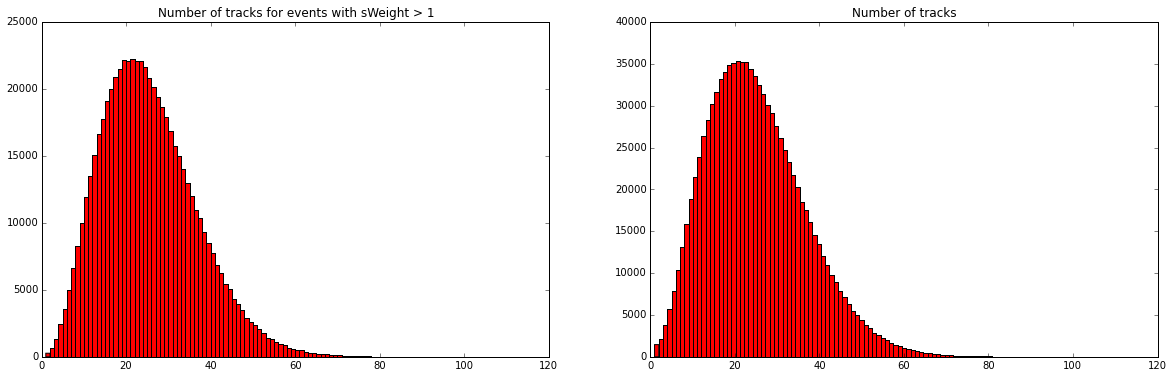

In [54]:
figure(figsize=(20, 6))

subplot(1, 2, 1)
_, n_tracks = numpy.unique(data_sw_passed[event_id_column], return_counts=True)
hist(n_tracks, bins=100)    
title('Number of tracks for events with sWeight > 1')

subplot(1, 2, 2)
_, n_tracks_all = numpy.unique(data[event_id_column], return_counts=True)
hist(n_tracks_all, bins=106)    
title('Number of tracks')

plt.savefig('img/tracks_number_less_PID.png' , format='png')

## PIDs histograms

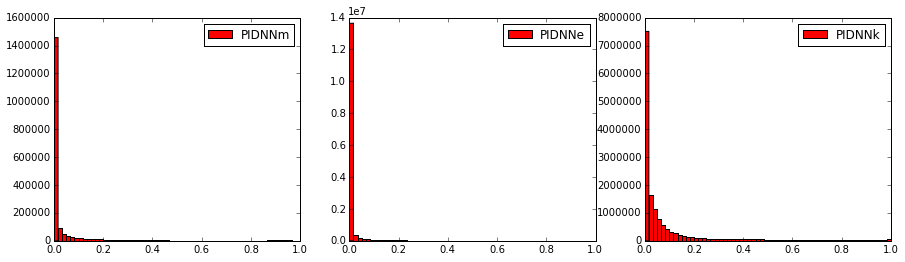

In [29]:
figure(figsize=[15, 4])
for i, column in enumerate(['PIDNNm', 'PIDNNe', 'PIDNNk']):
    subplot(1, 3, i + 1)
    hist(data_sw_passed[column].values, bins=60, range=(0, 1), label=column)
    legend()

----

## Train to distinguish same sign vs opposite sign

In [30]:
from rep.estimators import XGBoostClassifier

In [31]:
data_sw_passed_lds = LabeledDataStorage(data_sw_passed, data_sw_passed.label, data_sw_passed.N_sig_sw.values)

### DT

In [ ]:
xgb_base = XGBoostClassifier(n_estimators=200, colsample=0.7, eta=0.01, nthreads=12, 
                             subsample=0.1, max_depth=6)

# tt_base = DecisionTrainClassifier(learning_rate=0.02, n_estimators=3000, depth=6, pretransform_needed=True, 
#                                   max_features=15, loss=LogLossFunction(regularization=100), n_threads=8)
tt_folding = FoldingGroupClassifier(xgb_base, n_folds=2, random_state=11, 
                                    train_features=features, group_feature='group_column')
%time tt_folding.fit_lds(data_sw_passed_lds)
pass

In [ ]:
import cPickle
with open('models/xgb_full_group.pkl', 'w') as f:
    cPickle.dump(tt_folding, f)

In [32]:
# import cPickle
# with open('models/dt_full_group.pkl', 'r') as f:
#     tt_folding = cPickle.load(f)

In [34]:
comparison_report = ClassificationReport({'tt': tt_folding}, data_sw_passed_lds)

KFold prediction using folds column


In [35]:
comparison_report.compute_metric(RocAuc())

OrderedDict([('tt', 0.51274013418275466)])

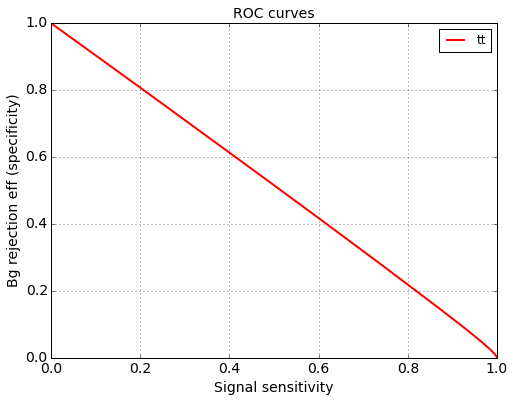

In [36]:
comparison_report.roc()

In [37]:
lc = comparison_report.learning_curve(RocAuc())

KFold prediction using folds column


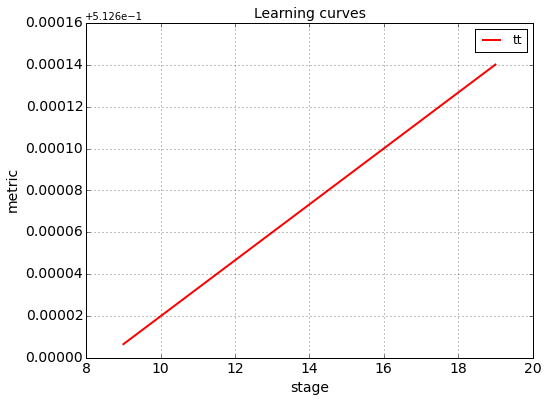

In [38]:
lc

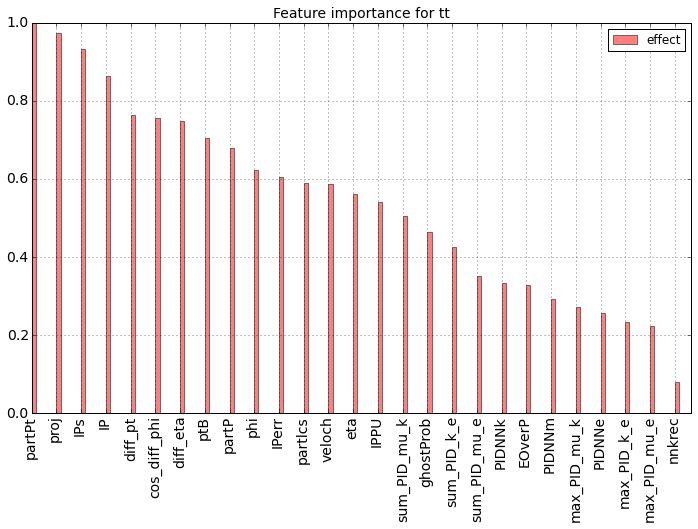

In [39]:
comparison_report.feature_importance()

---------

# Calibration

In [42]:
from utils import get_result_with_bootstrap_for_given_part

In [43]:
models = []

In [ ]:
models.append(get_result_with_bootstrap_for_given_part(tagging_efficiency, tagging_efficiency_delta, tt_folding, 
                                                      [data_sw_passed, data_sw_not_passed], 'tt-iso', logistic=False))

In [ ]:
models.append(get_result_with_bootstrap_for_given_part(tagging_efficiency, tagging_efficiency_delta, tt_folding, 
                                                      [data_sw_passed, data_sw_not_passed], 'tt-log', logistic=True))

In [ ]:
models.append(get_result_with_bootstrap_for_given_part(tagging_efficiency, tagging_efficiency_delta, tt_folding, 
                                                      [data_sw_passed, data_sw_not_passed], 'tt-iso-normed', 
                                                       logistic=False, normed_signs=True))

In [ ]:
models.append(get_result_with_bootstrap_for_given_part(tagging_efficiency, tagging_efficiency_delta, tt_folding, 
                                                      [data_sw_passed, data_sw_not_passed], 'tt-log-normed', 
                                                       logistic=True, normed_signs=True))

## Comparison table of different models

In [49]:
pandas.set_option('display.precision', 8)
result = pandas.concat(models)
result.index = result.name
result.drop('name', axis=1)

,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
name,,,,,,,,
tt-iso,99.9859475,0.11601489,0.05942814,0.00039399,5.94197903,0.03999200,64.03495514,0
tt-log,99.9859475,0.11601489,0.05926609,0.00051572,5.92577646,0.05202136,64.04009415,0
tt-iso-normed,99.9859475,0.11601489,0.04260567,0.00047307,4.25996846,0.04755816,61.70693765,0
tt-log-normed,99.9859475,0.11601489,0.04128878,0.00047796,4.12829737,0.04802869,61.60130636,0


In [50]:
pandas.set_option('display.precision', 8)
result = pandas.concat(models)
result.index = result.name
result.drop('name', axis=1)

,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
name,,,,,,,,
tt-iso,99.9859475,0.11601489,0.06309707,0.00041486,6.30882051,0.04212107,64.44915987,0
tt-log,99.9859475,0.11601489,0.06303423,0.00050728,6.30253717,0.05124538,64.43919397,0
tt-iso-normed,99.9859475,0.11601489,0.04630821,0.00046335,4.63017045,0.04663922,62.19639612,0
tt-log-normed,99.9859475,0.11601489,0.04596086,0.00052235,4.59543992,0.05249900,62.16389921,0


In [ ]:
result.ix[:2, :].to_csv('img/new-tagging_full_tracks.csv', index=False, header=True)

--------------------------

## Implementing best tracking

In [51]:
from utils import prepare_B_data_for_given_part

KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)


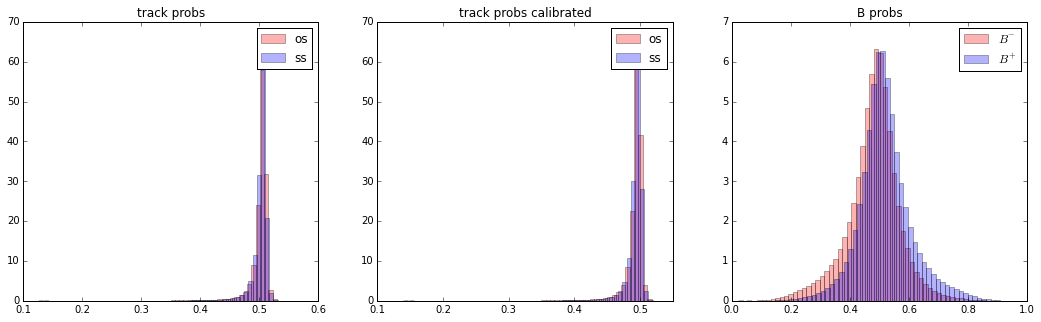

AUC for tagged: 0.644404492157 AUC with untag: 0.64439193972


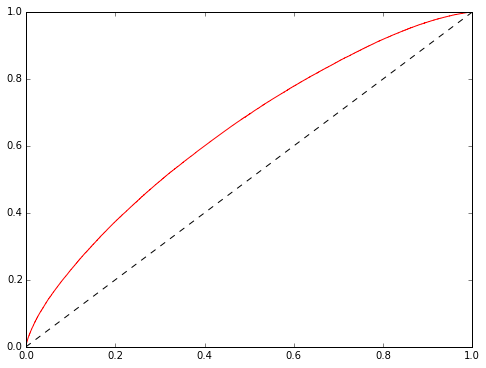

In [52]:
Bdata_prepared = prepare_B_data_for_given_part(tt_folding, [data_sw_passed, data_sw_not_passed], logistic=True)

In [53]:
Bdata_prepared.to_csv('models/Bdata_tracks_PID_less.csv', header=True, index=False)

### norm + and - tracks in B+ and B-

KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)


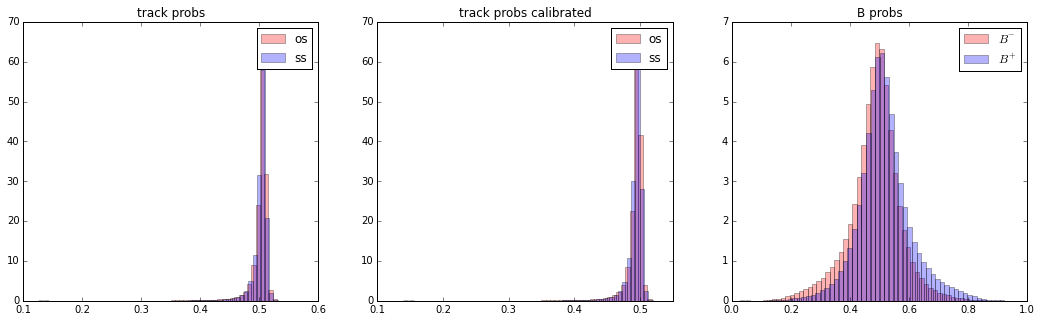

AUC for tagged: 0.621649895655 AUC with untag: 0.621638992141


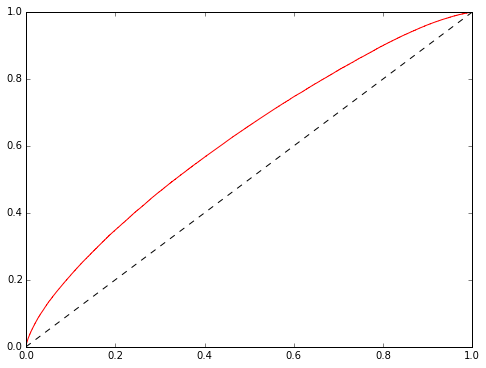

In [54]:
Bdata_prepared_normed = prepare_B_data_for_given_part(tt_folding, [data_sw_passed, data_sw_not_passed], 
                                                      logistic=True, normed_signs=True)

In [55]:
Bdata_prepared_normed.to_csv('models/Bdata_tracks_PID_less_normed.csv', header=True, index=False)